In [1]:
import math
import statistics
import matplotlib

import numpy as np
import pandas as pd

import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

## Daten

Umweltbundesamt:
https://www.umweltbundesamt.de/sites/default/files/medien/384/bilder/dateien/3-bis-8_abb-tab_tmt_2019-08-13.xlsx

In [2]:
DATA_PATH = "3-bis-8_abb-tab_tmt_2019-08-13.xlsx"

In [3]:
df = pd.read_excel(DATA_PATH, sheet_name="3_Daten", skiprows=8, usecols=[1,2,3], index_col=0)
df.index.name = "Jahr"
df.dropna(inplace=True)
df.columns = ['mittlere Tagesmittelwerte', 'Mittelwert 1961-1990']

In [4]:
df.head()

,mittlere Tagesmittelwerte,Mittelwert 1961-1990
Jahr,,
1881,7.3352,8.243483
1882,8.3661,8.243483
1883,7.9099,8.243483
1884,8.5892,8.243483
1885,7.7726,8.243483


Der Mittelwert der mittleren Tagesmitteltemperatur von 1961 - 1990 ist konstant

In [5]:
mTMT_Mittelwert = df["Mittelwert 1961-1990"][1881]
df = df.drop(["Mittelwert 1961-1990"], axis=1)
mTMT_Mittelwert

8.243483333333334

In [6]:
# Jahre als Integer Array
x = np.arange(df.index[0], df.index[0] + df.index.size)

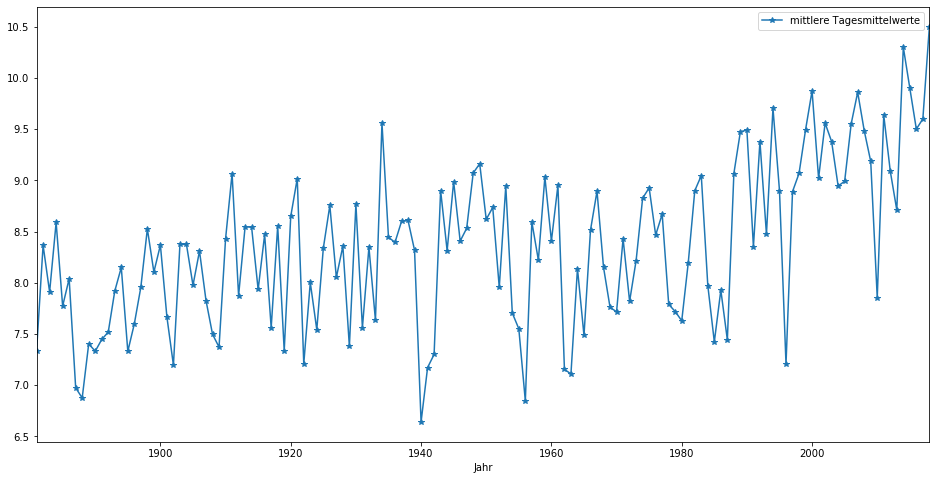

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
df.plot.line(ax=ax, marker="*", )

## Lineares Modell

In [8]:
def linear(x, intercept, slope):
    return intercept + slope * x

In [9]:
# Linear fit
p_linear, cov = opt.curve_fit(linear, df.index, df["mittlere Tagesmittelwerte"].values)
print(p_linear, cov)

residuals_linear = linear(x, *p_linear) - df["mittlere Tagesmittelwerte"].values

[-1.27903153e+01  1.08456401e-02] [[ 7.50755359e+00 -3.84940763e-03]
 [-3.84940763e-03  1.97456151e-06]]


## Lineares Modell auf den letzten 20 Jahren

In [10]:
df.tail(20).index

Int64Index([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Jahr')

In [11]:
p_linear20, cov = opt.curve_fit(linear, df.tail(20).index, df.tail(20)["mittlere Tagesmittelwerte"].values)
print(p_linear20, cov)

residuals_linear20 = linear(x, *p_linear20) - df["mittlere Tagesmittelwerte"].values

[-3.42723884e+01  2.17544799e-02] [[ 2.04948060e+03 -1.02039517e+00]
 [-1.02039517e+00  5.08038424e-04]]


## Polynomielles Modell

In [12]:
def poly3(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3

In [13]:
p_poly, cov = opt.curve_fit(poly3, df.index, df["mittlere Tagesmittelwerte"].values)
print(p_poly, cov)

residuals_poly = poly3(x, *p_poly) - df["mittlere Tagesmittelwerte"].values

[-2.62941827e+04  4.06889253e+01 -2.09811983e-02  3.60625957e-06] [[ 6.13745442e+07 -9.44839402e+04  4.84727416e+01 -8.28718708e-03]
 [-9.44839402e+04  1.45459898e+02 -7.46274198e-02  1.27592025e-05]
 [ 4.84727416e+01 -7.46274198e-02  3.82885685e-05 -6.54650911e-09]
 [-8.28718709e-03  1.27592025e-05 -6.54650912e-09  1.11935015e-12]]


## Exponentielles Modell

In [14]:
def exp(x, b, c):
    return np.exp(b / 1880 * x) + c

In [15]:
p_exp, cov = opt.curve_fit(exp, df.index, df["mittlere Tagesmittelwerte"].values, p0=[1, 5]) #, bounds=([0, 0.9, 0], [10, 1.1, 10]
print(p_exp, cov)

residuals_exp = exp(x, *p_exp) - df["mittlere Tagesmittelwerte"].values

[ 2.16916423 -1.13836808] [[ 0.00728482 -0.07176824]
 [-0.07176824  0.71015655]]


## Angepasste Modelle und Daten

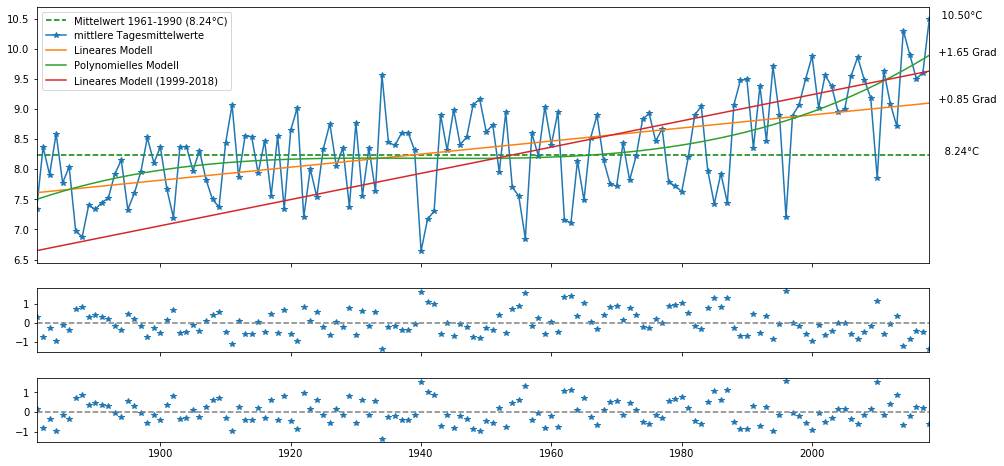

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16,8), sharex=True, gridspec_kw={'height_ratios': [4, 1, 1]})

# Horizontale Linie für Mittelwert
ax1.axhline(mTMT_Mittelwert, color="g", linestyle="--", label=f"Mittelwert 1961-1990 ({mTMT_Mittelwert:.2f}°C)")

# Daten
df.plot.line(ax=ax1, marker="*")
ax1.annotate(s=f"{mTMT_Mittelwert:>9.2f}°C", xy=(x[-1], mTMT_Mittelwert))

# Lineares Model
ax1.plot(df.index, linear(x, *p_linear), label='Lineares Modell')
diff_linear = linear(x, *p_linear)[-1] - mTMT_Mittelwert
ax1.annotate(s=f"{diff_linear:>+8.2f} Grad", xy=(x[-1], linear(x[-1], *p_linear)))

# Model mit Polynom 3. Grades
ax1.plot(df.index, poly3(x, *p_poly), label='Polynomielles Modell')
diff_poly = poly3(x, *p_poly)[-1] - mTMT_Mittelwert
ax1.annotate(s=f"{diff_poly:>+8.2f} Grad", xy=(x[-1], poly3(x[-1], *p_poly)))

# Lineares Modell auf den letzten 20 Jahren
ax1.plot(df.index, linear(x, *p_linear20), label='Lineares Modell (1999-2018)')

t_end = df["mittlere Tagesmittelwerte"].values[-1]
ax1.annotate(s=f"{t_end:>9.2f}°C", xy=(x[-1], t_end))

ax1.legend();

ax2.plot(x, residuals_linear, marker="*", linestyle="")
ax2.axhline(0, color="gray", linestyle="--")

ax3.plot(x, residuals_poly, marker="*", linestyle="")
ax3.axhline(0, color="gray", linestyle="--")

ax1.set_xlim(left=x[0], right=x[-1])

plt.savefig("trend-data-uba.png")

## Residuen

In [17]:
d_linear = statistics.NormalDist.from_samples(residuals_linear)
d_poly = statistics.NormalDist.from_samples(residuals_poly)
print(d_linear)
print(d_poly)

NormalDist(mu=-4.235635320742651e-09, sigma=0.6551807139588993)
NormalDist(mu=3.585048646354247e-08, sigma=0.61026843532889)


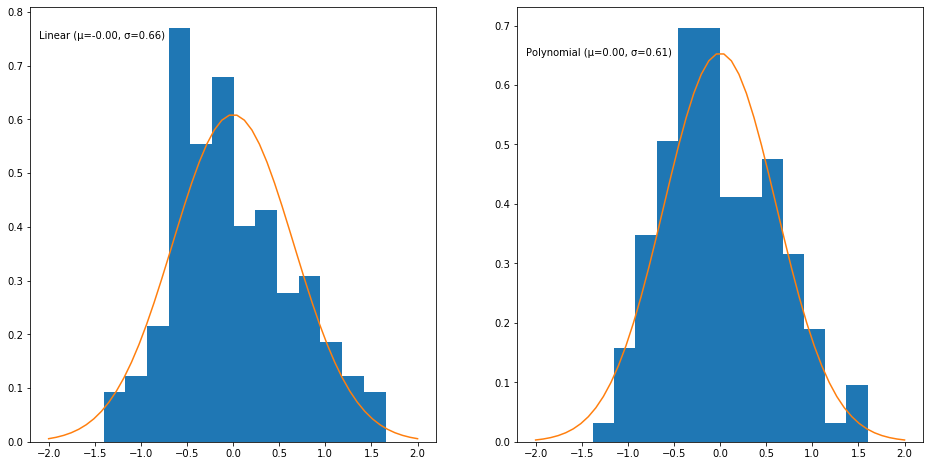

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))

x_range = np.linspace(-2, +2)

nbins = 13

ax1.hist(residuals_linear, bins=nbins, density=True)
ax1.plot(x_range, stats.norm.pdf(x_range, loc=d_linear.mean, scale=d_linear.stdev))
ax1.annotate(s=f"Linear (µ={d_linear.mean:.2f}, σ={d_linear.stdev:.2f})", xy=(-2.1,0.75))

ax2.hist(residuals_poly, bins=nbins, density=True)
ax2.plot(x_range, stats.norm.pdf(x_range, loc=d_poly.mean, scale=d_poly.stdev))
ax2.annotate(s=f"Polynomial (µ={d_poly.mean:.2f}, σ={d_poly.stdev:.2f})", xy=(-2.1,0.65))

plt.savefig("trend-data-uba-residuen.png")